### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for Atari [Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with Advantage Actor-Critic.

Note that, strictly speaking, this will be neither [A3C](https://arxiv.org/abs/1602.01783) nor [A2C](https://openai.com/blog/baselines-acktr-a2c/), but rather a simplified version of the latter.

![https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/submit.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/atari_util.py

        !touch .setup_complete

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

For starters, let's take a look at the game itself:

* Image resized to 42x42 and converted to grayscale to run faster
* Agent sees last 4 frames of game to account for object velocity

In [3]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


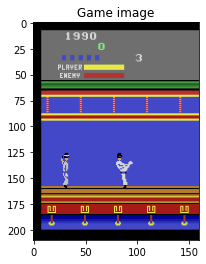

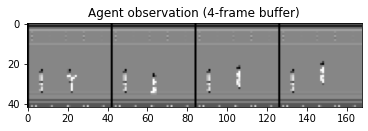

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42, -1]), cmap='gray')
plt.show()

### Build an agent

We now have to build an agent for actor-critic training — a convolutional neural network that converts states into action probabilities $\pi$ and state values $V$.

Your assignment here is to build and apply a neural network. You can use any framework you want, but in this notebook we prepared for you a template in Tensorflow.

For starters, we want you to implement this architecture:

![https://s17.postimg.cc/orswlfzcv/nnet_arch.png](https://s17.postimg.cc/orswlfzcv/nnet_arch.png)

Notes:

* Use convolution kernel size 3x3 throughout.
* After your agent gets mean reward above 5000, we encourage you to experiment with model architecture to score even better.

In [5]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Input

Using TensorFlow backend.


In [8]:
class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            # Prepare neural network architecture
            # prepare any necessary layers, variables, etc.
            inputs = Input(state_shape)
            x = Conv2D(32, (3,3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3,3),strides=2, activation='relu')(x)
            x = Conv2D(32, (3,3),strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)

            logit = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)

            self.network = Model(input=inputs, outputs=[logit, state_value])

            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        # apply the agent's neural network to get policy logits and state values
        
        logits, state_values = self.network(state_t)
        state_values = state_values[:, 0]
        
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "Please return 2D TF tensor of logits [you got %s]." % repr(logits)
        assert tf.is_numeric_tensor(state_values) and state_values.shape.ndims == 1, \
            "Please return 1D TF tensor of state values [you got %s]." % repr(state_values)
        # Hint: if you triggered state_values assert with your shape being [None, 1],
        # just select [:, 0]-th element of state values as new state values.
        # Alternatively, you can do tf.squeeze(state_values, axis=1).
        
        return logits, state_values
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [9]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("ag...)`


In [10]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.03956417 -0.01208175 -0.09438052 -0.03045924  0.01056613  0.08465123
  -0.06936754 -0.08289995  0.04806804 -0.00764245 -0.05248307 -0.00310642
  -0.02879252  0.04336025]]
state values:
 [0.03677584]


### Let's play!
Let's build a function that measures agent's average reward.

In [11]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [12]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    rewards = evaluate(agent, env_monitor, n_games=3)

print(rewards)

[1000.0, 1100.0, 800.0]


In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

### Training on parallel games

![img](https://s7.postimg.cc/4y36s2b2z/env_pool.png)


To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.

In [14]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [15]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()
batch_actions = agent.sample_actions(agent.step(batch_states))
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

State shape: (10, 42, 42, 4)
Actions: [ 7 10  8  5  0  8  8  6 11  7]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]


# Actor-critic

Here we define loss functions and learning algorithms as usual.

In [16]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [17]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)

# There is no next state if the episode is done!
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits, axis=-1)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits, axis=-1)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [18]:
# Compute advantage using rewards_ph, state_values and next_state_values.
gamma = 0.99
advantage = rewards_ph + gamma * next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# Compute policy entropy given logits_seq. Mind the "-" sign!
entropy = -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "

# Compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph + gamma * next_state_values


actor_loss = -tf.reduce_mean(logp_actions * tf.stop_gradient(advantage), axis=0) - 0.001 * tf.reduce_mean(entropy, axis=0)
critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2, axis=0)

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2:
    print("Entropy is too low for an untrained agent")
print("You just might be fine!")

You just might be fine!


# Train 

Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.

![Daniel San training the Karate Kid](https://media.giphy.com/media/W4uQMqlKVoiXK89T5j/giphy.gif)

In [20]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

Please pay extra attention to how we scale rewards in training. We do that for multiple reasons.

1. All rewards are multiples of 100, and even an untrained agent can get a score of 800. Therefore, even in the beginning of training, the critic will have to predict pretty large numbers. Neural networks require extra tinkering to output large numbers reliably. In this case, the easiest workaround is just to scale back those numbers.
2. We have already tweaked the hyperparameters (loss coefficients) to work well with this scaling.

Please note however that we would not have needed to do this in plain REINFORCE without entropy regularization but with Adam optimizer.

In REINFORCE, there is only actor and no critic. Without entropy regularization, actor loss is just policy gradient. It is proportional to rewards, but it only affects the scale of the gradient. However, Adam maintains a running average of the variance of the gradient for each parameter it optimizes, and normalizes the gradient by its variance in each optimization step. This will negate any scaling of the gradient.

If your implementation works correctly, you can comment out the `batch_rewards = batch_rewards * 0.01` line, restart training, and see it explode.

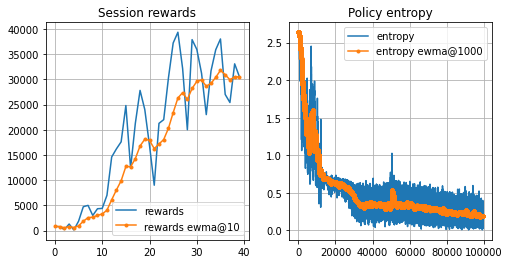

100%|██████████| 100000/100000 [1:06:11<00:00, 25.18it/s]


In [21]:
import tqdm
from IPython.display import clear_output

with tqdm.trange(len(entropy_history), 100000) as t:
    for i in t:
        agent_outputs = agent.step(batch_states)
        batch_actions = agent.sample_actions(agent_outputs)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

        # Reward scaling. See above for explanation.
        batch_rewards = batch_rewards * 0.01

        feed_dict = {
            states_ph: batch_states,
            actions_ph: batch_actions,
            next_states_ph: batch_next_states,
            rewards_ph: batch_rewards,
            is_done_ph: batch_done,
        }

        _, ent_t = sess.run([train_step, entropy], feed_dict)
        entropy_history.append(np.mean(ent_t))

        batch_states = batch_next_states

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
                if rewards_history[-1] >= 5000:
                    print("Your agent has earned the yellow belt")

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(entropy_history, label='entropy')
            plt.plot(ewma(np.array(entropy_history), span=1000), marker='.', label='entropy ewma@1000')
            plt.title("Policy entropy")
            plt.grid()
            plt.legend()
            plt.show()

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it doesn't increase substantially before some 10-20k initial steps, and some people who tried this assignment [told us](https://www.coursera.org/learn/practical-rl/discussions/all/threads/3OnFNVxEEemLZA644RFX2A) they didn't see improvements until around 60k steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.

Since we use a policy-based method, we also keep track of __policy entropy__ — the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $-\sum p(a_i) \cdot \log p(a_i)$.
* Your model architecture is broken in some way: for example, if you create layers in `Agent.symbolic_step()` rather than in `Agent.__init__()`, then effectively you will be training two separate agents: one for `logits, state_values` and another one for `next_logits, next_state_values`.
* Your architecture is different from the one we suggest and it converges too quickly. Change your architecture or increase entropy coefficient in actor loss. 
* Gradient explosion: just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

In [22]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=3)

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: 32466.666666666668


In [23]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))

In [24]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-2]))  # You can also try other indices

If you don't see videos above, just navigate to `./videos` and download `.mp4` files from there.

In [25]:
from submit import submit_kungfu
env = make_env()
submit_kungfu(agent, env, evaluate, 'iskander0697@gmail.com', 'BZliXN50XsNBwVBs')

Evaluating your agent: 100%|██████████| 10/10 [01:37<00:00,  9.72s/it]


Your average reward is 32600.0 over 10 episodes
Submitted to Coursera platform. See results on assignment page!


### Now what?
Well, 5k reward is [just the beginning](https://www.buzzfeed.com/mattjayyoung/what-the-color-of-your-karate-belt-actually-means-lg3g). Can you get past 200? With recurrent neural network memory, chances are you can even beat 400!

* Try n-step advantage and "lambda"-advantage (aka GAE) - see [this article](https://arxiv.org/abs/1506.02438)
 * This change should improve early convergence a lot
* Try recurrent neural network 
 * RNN memory will slow things down initially, but in will reach better final reward at this game
* Implement asynchronuous version
 * Remember [A3C](https://arxiv.org/abs/1602.01783)? The first "A" stands for asynchronuous. It means there are several parallel actor-learners out there.
 * You can write custom code for synchronization, but we recommend using [redis](https://redis.io/)
   * You can store full parameter set in redis, along with any other metadate
   * Here's a _quick_ way to (de)serialize parameters for redis
   ```
   import joblib
   from six import BytesIO
```
```
   def dumps(data):
        "converts whatever to string"
        s = BytesIO()
        joblib.dump(data,s)
        return s.getvalue()
``` 
```
    def loads(string):
        "converts string to whatever was dumps'ed in it"
        return joblib.load(BytesIO(string))
```